In [ ]:
from ctypes import Structure
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt


The dataset includes 23 columns, excluding the ID columns.

Customer satisfaction is going to be our binary outcome variable (satisfied or not satisfied/neutral).
Numeric variables are age, flight distance, arrival delay and departure delay in minutes.
Nominal (unordered) factor variables are gender, customer loyalty (loyal or disloyal), type of travel (personal or business) and class (business, eco, ecoplus).
Ordered factor variables are the 1-5 satisfaction ratings for various aspects of service, such as:
Wifi service,
Convenience of departure and arrival time,
Ease of online booking,
Gate location,
Food and drink,
and 9 more ratings.

In [ ]:
train_air = pd.read_csv('train_air.csv')
test_air = pd.read_csv('test_air.csv')

train_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [ ]:
#identify missing values
train_air.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

Задача - построить модель классификации для определения класса пассажира.

In [ ]:
#все признаки object переведем в категориальные, а потом разберемся, что с ними делать
train_air[['Class','Gender','Customer Type','Type of Travel','satisfaction']]=train_air[['Class','Gender','Customer Type','Type of Travel','satisfaction']].astype('category')
test_air[['Class','Gender','Customer Type','Type of Travel','satisfaction']]=test_air[['Class','Gender','Customer Type','Type of Travel','satisfaction']].astype('category')

# Разделение данных на обучающий и тестовый наборы

#удаление столбцов с целевой переменной 'Class' и 'Arrival Delay in Minutes', содержащего пропущенные значения
#(выбор класса перелета никак не зависит от такого признака, как задержка времени прибытия)
#заодно все столбцы с категориальными признаками (логистическая регрессия их не принимает)

x_train = train_air.drop(['Class','Arrival Delay in Minutes','Gender','Customer Type','Type of Travel','satisfaction'], axis = 1)
y_train = train_air['Class']
x_test=test_air.drop(['Class','Arrival Delay in Minutes','Gender','Customer Type','Type of Travel','satisfaction'], axis = 1)
y_test=test_air['Class']

# Нормализация признаков
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


гистограммы, для оценки соотношения встречаемости классов в обучающей и тестовой выборках

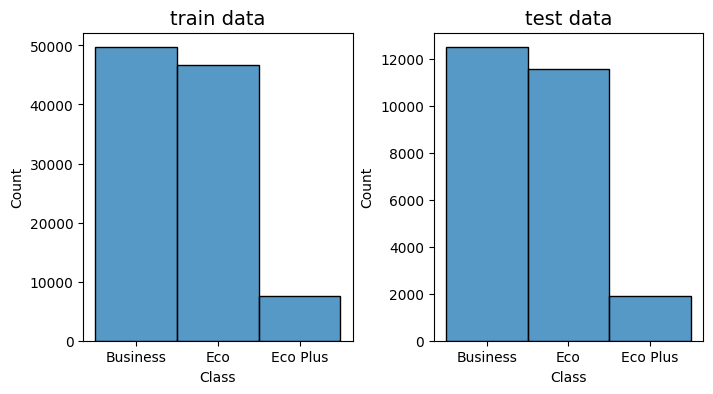

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,
                                    figsize = (8, 4),
                                    gridspec_kw = {'wspace': 0.3, 'hspace': 0.3})

sns.histplot(y_train, ax = ax1)
ax1.set_title('train data', fontsize = 14)

sns.histplot(y_test, ax = ax2)
ax2.set_title('test data', fontsize = 14)

plt.show()

**Логистическая регрессия** решает задачу бинарной классификации, но так как у целевого признака три категории ('Eco','Eco Plus','Business') рассмотрим подходы мультиклассовой логистической регрессии.

In [ ]:
#для того чтобы применить подход one-vs-rest в классе LogisticRegression, необходимо использовать значение параметра multi_class = ‘ovr’
#чтобы использовать softmax логистическую регрессию в sklearn, параметр multi_class = ‘multinomial’
#оба параметра дают практически одинаковый результат (оставила лучший)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

#model = LogisticRegression(multi_class = 'ovr')
model = LogisticRegression(multi_class = 'multinomial')

model.fit(x_train, y_train, sample_weight=None)
y_pred = model.predict(x_test)
accuracy_score(y_pred, y_test)

0.7107714813674161

In [ ]:
confusion_matrix(y_pred, y_test)

array([[9243, 2344,  346],
       [3252, 9220, 1571],
       [   0,    0,    0]])

Глядя на матрицу, возникает вопрос - где третий класс? Похоже-таки, бинарная классификация...

**Рассмотрим полиномиальную регрессию (2 степени)**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree = 2)

#трансформируем обучающую и тестовую выборки
x_trainpoly = polynomial_features.fit_transform(x_train)
x_testpoly = polynomial_features.fit_transform(x_test)

poly_ovr_model = LogisticRegression(multi_class = 'ovr')
poly_ovr_model = poly_ovr_model.fit(x_trainpoly, y_train)
y_pred = poly_ovr_model.predict(x_testpoly)

accuracy_score(y_pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7759855251000924

In [ ]:
confusion_matrix(y_pred, y_test)

array([[10170,  1578,   292],
       [ 2324,  9985,  1623],
       [    1,     1,     2]])

**Вернем категориальные данные, предварительно преобразовав их в числовые данные, используя LabelEncoder.**

In [ ]:
from sklearn.preprocessing import LabelEncoder
LabEn = LabelEncoder()
train_air1=train_air
test_air1=test_air

#train_air1[['Gender','Customer Type','Type of Travel','satisfaction']]=LabEn.fit_transform(train_air1[['Gender','Customer Type','Type of Travel','satisfaction']])
train_air1['Gender']=LabEn.fit_transform(train_air1['Gender'])
train_air1['Customer Type']=LabEn.fit_transform(train_air1['Customer Type'])
train_air1['Type of Travel']=LabEn.fit_transform(train_air1['Type of Travel'])
train_air1['satisfaction']=LabEn.fit_transform(train_air1['satisfaction'])

test_air1['Gender']=LabEn.fit_transform(test_air1['Gender'])
test_air1['Customer Type']=LabEn.fit_transform(test_air1['Customer Type'])
test_air1['Type of Travel']=LabEn.fit_transform(test_air1['Type of Travel'])
test_air1['satisfaction']=LabEn.fit_transform(test_air1['satisfaction'])

x_train = train_air1.drop(['Class','Arrival Delay in Minutes'], axis = 1)
y_train = train_air1['Class']
x_test=test_air1.drop(['Class','Arrival Delay in Minutes'], axis = 1)
y_test=test_air1['Class']

# Нормализация признаков
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LogisticRegression(multi_class = 'multinomial')

model.fit(x_train, y_train, sample_weight=None)
y_pred = model.predict(x_test)
accuracy_score(y_pred, y_test)


0.7817600862334463

In [ ]:
confusion_matrix(y_pred, y_test)

array([[10604,  1861,   470],
       [ 1891,  9703,  1447],
       [    0,     0,     0]])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree = 2)

#трансформируем обучающую и тестовую выборки
x_trainpoly = polynomial_features.fit_transform(x_train)
x_testpoly = polynomial_features.fit_transform(x_test)

poly_ovr_model = LogisticRegression(multi_class = 'multinomial')
poly_ovr_model = poly_ovr_model.fit(x_trainpoly, y_train)
y_pred = poly_ovr_model.predict(x_testpoly)

accuracy_score(y_pred, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8285725284878349

In [ ]:
confusion_matrix(y_pred, y_test)

array([[11043,  1083,   262],
       [ 1451, 10471,  1646],
       [    1,    10,     9]])

Дерево решений (с категориальными признаками не строится)

In [ ]:
train_air1 = pd.read_csv('train_air.csv')
test_air1 = pd.read_csv('test_air.csv')

train_air1['Gender']=LabEn.fit_transform(train_air1['Gender'])
train_air1['Customer Type']=LabEn.fit_transform(train_air1['Customer Type'])
train_air1['Type of Travel']=LabEn.fit_transform(train_air1['Type of Travel'])
train_air1['satisfaction']=LabEn.fit_transform(train_air1['satisfaction'])

test_air1['Gender']=LabEn.fit_transform(test_air1['Gender'])
test_air1['Customer Type']=LabEn.fit_transform(test_air1['Customer Type'])
test_air1['Type of Travel']=LabEn.fit_transform(test_air1['Type of Travel'])
test_air1['satisfaction']=LabEn.fit_transform(test_air1['satisfaction'])
x_train = train_air1.drop(['Class','Arrival Delay in Minutes'], axis = 1)
y_train = train_air1['Class']
x_test=test_air1.drop(['Class','Arrival Delay in Minutes'], axis = 1)
y_test=test_air1['Class']

from sklearn import tree
cl_tree = tree.DecisionTreeClassifier()
clf = cl_tree.fit(x_train, y_train)
y_pred=cl_tree.predict(x_test)
accuracy_score(y_pred, y_test)



0.7896904835232522